In [1]:
!pip install easy_vqa

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import json
import os
import numpy as np
from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from matplotlib.pyplot import imshow

def setup(use_data_dir):
    print('\n--- Reading questions...')
    if use_data_dir:
        def read_questions(path):
            with open(path, 'r') as file:
                qs = json.load(file)
            texts = [q[0] for q in qs]
            answers = [q[1] for q in qs]
            image_ids = [q[2] for q in qs]
            return (texts, answers, image_ids)
        train_qs, train_answers, train_image_ids = read_questions('data/train/questions.json')
        test_qs, test_answers, test_image_ids = read_questions('data/test/questions.json')
    else:
        train_qs, train_answers, train_image_ids = get_train_questions()
        test_qs, test_answers, test_image_ids = get_test_questions()
    print(f'Read {len(train_qs)} training questions and {len(test_qs)} testing questions.')


    print('\n--- Reading answers...')
    if use_data_dir:
        with open('data/answers.txt', 'r') as file:
              all_answers = [a.strip() for a in file]
    else:
        # Read answers from the easy-vqa package
        all_answers = get_answers()
        num_answers = len(all_answers)
        print(f'Found {num_answers} total answers:')
    print(all_answers)


    print('\n--- Reading/processing images...')
    def load_and_proccess_image(image_path):
        im = img_to_array(load_img(image_path))
        return im / 255 - 0.5

    def read_images(paths):
        ims = {}
        for image_id, image_path in paths.items():
              ims[image_id] = load_and_proccess_image(image_path)
        return ims

    if use_data_dir:
        def extract_paths(dir):
            paths = {}
            for filename in os.listdir(dir):
                if filename.endswith('.png'):
                    image_id = int(filename[:-4])
                    paths[image_id] = os.path.join(dir, filename)
            return paths

        train_ims = read_images(extract_paths('data/train/images'))
        test_ims  = read_images(extract_paths('data/test/images'))
    else:
        train_ims = read_images(get_train_image_paths())
        test_ims = read_images(get_test_image_paths())
    im_shape = train_ims[0].shape
    print(f'Read {len(train_ims)} training images and {len(test_ims)} testing images.')
    print(f'Each image has shape {im_shape}.')


    print('\n--- Fitting question tokenizer...')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_qs)

    vocab_size = len(tokenizer.word_index) + 1
    print(f'Vocab Size: {vocab_size}')
    print(tokenizer.word_index)


    print('\n--- Converting questions to bags of words...')
    train_X_seqs = tokenizer.texts_to_matrix(train_qs)
    test_X_seqs = tokenizer.texts_to_matrix(test_qs)
    print(f'Example question bag of words: {train_X_seqs[0]}')


    print('\n--- Creating model input images...')
    train_X_ims = np.array([train_ims[id] for id in train_image_ids])
    test_X_ims = np.array([test_ims[id] for id in test_image_ids])


    print('\n--- Creating model outputs...')
    train_answer_indices = [all_answers.index(a) for a in train_answers]
    test_answer_indices = [all_answers.index(a) for a in test_answers]
    train_Y = to_categorical(train_answer_indices)
    test_Y = to_categorical(test_answer_indices)
    print(f'Example model output: {train_Y[0]}')

    return (train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs,
          test_Y, im_shape, vocab_size, num_answers,
          all_answers, test_qs, test_answer_indices, tokenizer)


In [3]:
train_X_ims, train_X_seqs, train_Y, test_X_ims, test_X_seqs, test_Y, im_shape, vocab_size, num_answers, all_answers, test_qs, test_answer_indices, tokenizer = setup('')


--- Reading questions...
Read 38575 training questions and 9673 testing questions.

--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']

--- Reading/processing images...
Read 4000 training images and 1000 testing images.
Each image has shape (64, 64, 3).

--- Fitting question tokenizer...
Vocab Size: 27
{'is': 1, 'shape': 2, 'the': 3, 'a': 4, 'image': 5, 'there': 6, 'not': 7, 'what': 8, 'present': 9, 'does': 10, 'contain': 11, 'in': 12, 'color': 13, 'no': 14, 'circle': 15, 'rectangle': 16, 'triangle': 17, 'brown': 18, 'yellow': 19, 'gray': 20, 'teal': 21, 'black': 22, 'red': 23, 'green': 24, 'blue': 25, 'of': 26}

--- Converting questions to bags of words...
Example question bag of words: [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]

--- Creating model input images...

--- Creating model outputs...
Example model output: [0. 0. 0. 0. 0. 

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply
from tensorflow.keras.optimizers import Adam


class Easy_VQA_model(tf.keras.Model):
    def __init__(self):
        super(Easy_VQA_model, self).__init__()
        self.conv2d1 = Conv2D(8, 3, padding='same')
        self.maxpool2d1 = MaxPooling2D()
        self.conv2d2 = Conv2D(16, 3, padding='same')
        self.maxpool2d2 = MaxPooling2D()
        self.conv2d3 = Conv2D(32, 3, padding='same')
        self.maxpool2d3 = MaxPooling2D()
        self.flatten = Flatten()
        self.im_fc = Dense(32, activation='tanh')
        
        self.qs_fc1 = Dense(32, activation='tanh')
        self.qs_fc2 = Dense(32, activation='tanh')
        
        self.multp = Multiply()
        self.concat_fc1 = Dense(32, activation='tanh')
        self.concat_fc2 = Dense(num_answers, activation='softmax')
    
    def call(self, inputs):
        #Image input
        x1 = self.conv2d1(inputs[0])
        x1 = self.maxpool2d1(x1)
        
        x1 = self.conv2d2(x1)
        x1 = self.maxpool2d2(x1)
        
        x1 = self.conv2d3(x1)
        x1 = self.maxpool2d3(x1)
        
        x1 = self.flatten(x1)
        x1 = self.im_fc(x1)
        
        #Question input
        x2 = self.qs_fc1(inputs[1])
        x2 = self.qs_fc2(x2)
        
        #Unite
        x = self.multp([x1,x2])
        x = self.concat_fc1(x)
        return self.concat_fc2(x)
    
    def model(self, im_shape, vocab_size):
        x1, x2  = Input(shape=im_shape), Input(shape=(vocab_size,))
        return Model(inputs=[x1, x2], outputs=self.call([x1, x2]))
        

In [5]:
img_inp = Input(shape=im_shape)
qs_inp = Input(shape=(vocab_size,))


model = Easy_VQA_model()
model = model.model(im_shape, vocab_size)
model.compile(Adam(lr=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    224         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   1168        max_pooling2d[0][0]              
_______________________________________________________________________________________

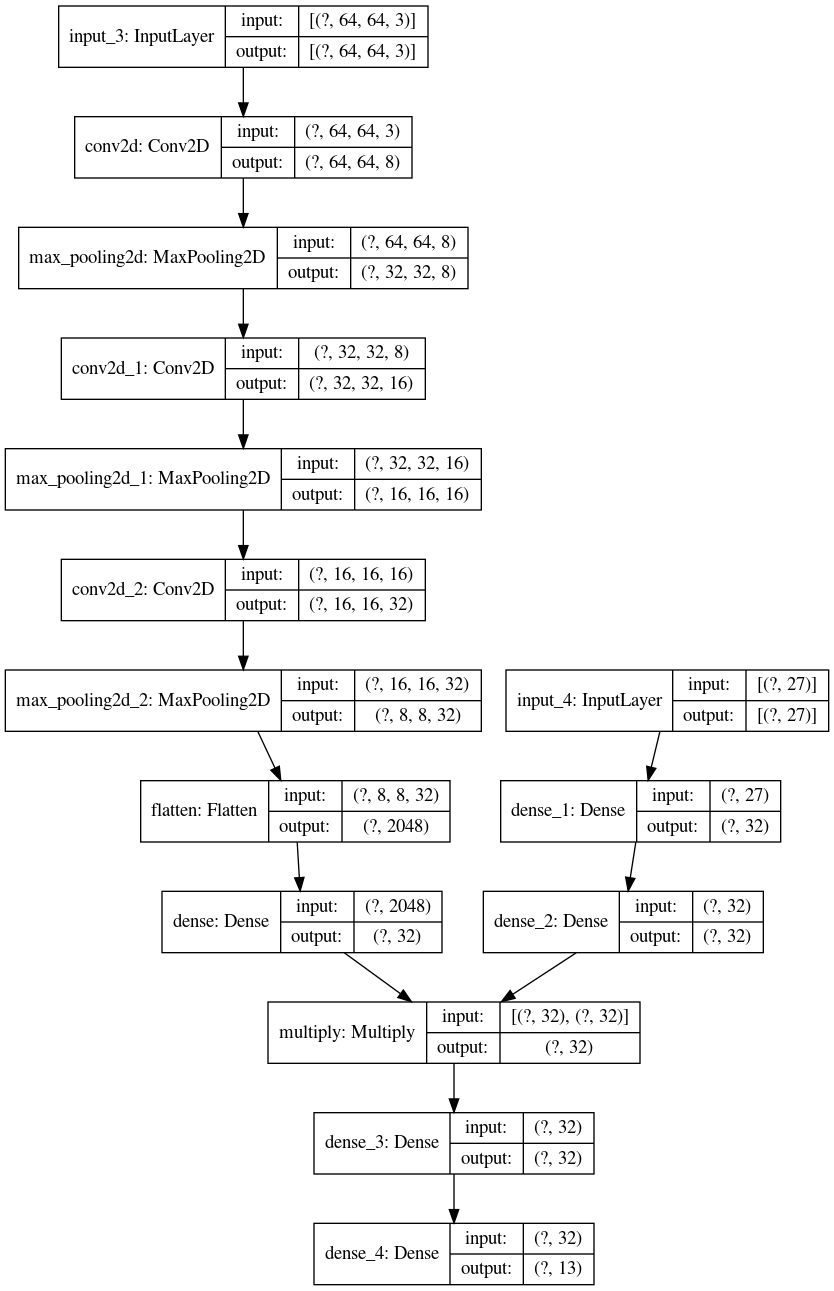

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.fit(
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=50,
)

Epoch 1/50
1206/1206 [==============================] - 8s 7ms/step - loss: 0.8986 - accuracy: 0.6439 - val_loss: 0.7518 - val_accuracy: 0.6728
Epoch 2/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.7458 - accuracy: 0.6731 - val_loss: 0.7035 - val_accuracy: 0.6917
Epoch 3/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.6641 - accuracy: 0.7103 - val_loss: 0.6114 - val_accuracy: 0.7389
Epoch 4/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.5701 - accuracy: 0.7544 - val_loss: 0.5222 - val_accuracy: 0.7666
Epoch 5/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.4890 - accuracy: 0.7719 - val_loss: 0.4618 - val_accuracy: 0.7777
Epoch 6/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.4279 - accuracy: 0.7855 - val_loss: 0.4116 - val_accuracy: 0.7983
Epoch 7/50
1206/1206 [==============================] - 7s 6ms/step - loss: 0.3667 - accuracy: 0.8275 - val_loss: 0.3559 - val_accuracy:

<AxesSubplot:>

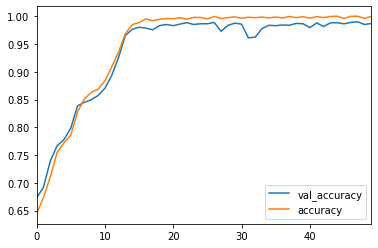

In [8]:
import pandas as pd
losses = pd.DataFrame(model.history.history)
losses[['val_accuracy', 'accuracy']].plot()

<AxesSubplot:>

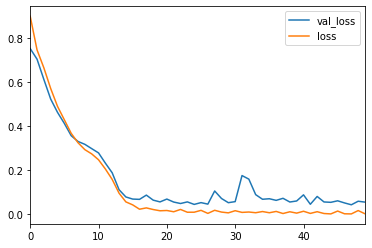

In [9]:
losses[['val_loss', 'loss']].plot()

In [10]:
prediction = model.predict([test_X_ims[0].reshape((-1, 64, 64, 3)), test_X_seqs[0].reshape((-1, 27))])

In [11]:
def make_prediction(model, tokenizer, all_answers, img, ques):
    ques_seq = tokenizer.texts_to_matrix(ques)
    prediction = model.predict([img.reshape((-1, 64, 64, 3)), ques_seq.reshape((-1, 27))])
    max_elem_id = prediction.argmax()
    answer = all_answers[max_elem_id]
    print(f"{ques[0]}\nPredicted answer: {answer}")
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


What color has a triangle on the image?
Predicted answer: red


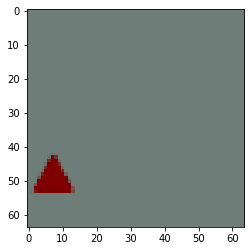

In [12]:
make_prediction(model, tokenizer, all_answers, test_X_ims[10], ["What color has a triangle on the image?"])